In [1]:
import pandas as pd
import numpy as np
import seaborn as sns # started with this, but it didn't suit my needs, but kept to practise 
import matplotlib.pyplot as plt
from pprint import pprint
import plotly.express as px

In [2]:

# Load difficulty_df and players from CSV file
difficulty_df = pd.read_csv('player_difficulty_data.csv')
players_df = pd.read_csv('selected_player_teams_data.csv')

# Replace missing values in 'EventName' with 'Gameweek 18'. It was loading weird and causing issues for calculations. 
#difficulty_df['EventName'].fillna('Gameweek 18', inplace=True)

# Pivot the DataFrame to match players_df. Will join later
pivot_df = difficulty_df.pivot_table(index='PlayerID', columns='EventName', values='Difficulty')

# sort vals
pivot_df_sorted = pivot_df.sort_values(by='PlayerID', ascending=True)

# reset index to make PlayerID a regular column. had issues without doing this
pivot_df.reset_index(inplace=True)

#join these boys together. Now can start to predict future performance based on past performance
full_df =  pd.merge(left=players_df, right=pivot_df, how='left', left_on='id_player', right_on='PlayerID')


#print(full_df.head())
#print(full_df.info())


In [3]:
# Changing the position code to shorthand for clear referencing
element_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
full_df["element_type"] = full_df["element_type"].replace(element_mapping)

# Rename to as element_type wasn't clear
full_df = full_df.rename(columns={'element_type': 'position'})

print(full_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id_player                     823 non-null    int64  
 1   first_name                    823 non-null    object 
 2   second_name                   823 non-null    object 
 3   position                      823 non-null    object 
 4   now_cost                      823 non-null    int64  
 5   name                          823 non-null    object 
 6   influence_rank                823 non-null    int64  
 7   form_rank                     823 non-null    int64  
 8   form_player                   823 non-null    float64
 9   in_dreamteam                  823 non-null    bool   
 10  news                          322 non-null    object 
 11  chance_of_playing_next_round  627 non-null    float64
 12  points_per_game               823 non-null    float64
 13  point

In [4]:
""" Now for some calculations. I was reading that form is a stat that FPL uses which is based on an aggregation of points from previous game weeks
as well as taking in consideration for ICT or impact, contribution and threat scores. Basically if the player is in good form of recent. 
Secondly, I took the difficulty rating for the upcoming 5 matches to give a score. Then divided this by form to make a metric for 'fixure difficulty'.
The higher the score, the more likely the player will perform and make points for the coming weeks. I tried with 3 games, but since only one sub is 
allowed per week, it was probably better to plan ahead for a while.
"""

# Had some negative values in form which was causing errors. Replace all neg vals with 0 instead
full_df["form_player"] = full_df["form_player"].clip(lower=0)

# Set the starting column index for Gameweek values(Check csv can change if needed. Find first game week)
gameweek_start_column = 32

# Sum the next 5 non-nan values for each row (if errors, reduce sum to remaining gameweeks left)
def sum_next_5_non_nan(row):
    non_nan_values = row.iloc[gameweek_start_column:].dropna().head(5)
    return np.sum(non_nan_values)

# Calculate 'Difficulty_score' for easy visualisation without concering players form
full_df["Difficulty_score"] = full_df.apply(sum_next_5_non_nan, axis=1).round(3)

# Calculate 'FD_index' or fixture difficulty index, using form divided by difficulty score
full_df["FD_index"] = (full_df["form_player"] / full_df["Difficulty_score"]).round(3)

# data gave weird names so was easier for me to recongnise some players this way
full_df['full_name'] = full_df['first_name'] + ' ' + full_df['second_name']

## Fallback code if want to check specific gameweeks 

# Calculate 'FD_index' using the selected Gameweek columns
#full_df["FD_index"] = (full_df["form_player"] / gameweek_columns.sum(axis=1)).round(3)

#full_df["FD_index"] = (full_df["form_player"] / full_df[["Gameweek 26", "Gameweek 27", "Gameweek 28", "Gameweek 29", "Gameweek 30"]].sum(axis=1)).round(3)

# for easy visualisation without concering players form
#full_df["Difficulty_score"] = full_df[["Gameweek 26", "Gameweek 27", "Gameweek 28", "Gameweek 29", "Gameweek 30"]].sum(axis=1).round(3)



#print(full_df.head())

In [5]:
full_df.to_csv('full_df.csv', index=False)

In [6]:
# Sorting and filtering by position: Forwards
forwards_df = full_df[full_df['position'] == 'FWD']
sorted_forwards_df = forwards_df.sort_values(by=['FD_index', 'expected_goals', 'expected_assists'], ascending=[False, False, False])

# Sorting and filtering Midfielders
midfielders_df = full_df[full_df['position'] == 'MID']
sorted_midfielders_df = midfielders_df.sort_values(by=['FD_index', 'expected_goals', 'expected_assists'], ascending=[False, False, False])

# Sorting and filtering Defenders
defenders_df = full_df[full_df['position'] == 'DEF']
sorted_defenders_df = defenders_df.sort_values(by=['FD_index', 'expected_goals', 'expected_assists'], ascending=[False, False, False])

# Sorting and filtering Goalkeepers
goalkeepers_df = full_df[full_df['position'] == 'GK']
sorted_goalkeepers_df = goalkeepers_df.sort_values(by=['FD_index', 'expected_goals', 'expected_assists'], ascending=[False, False, False])


# Display the resulting DataFrame
#print(sorted_forwards_df.head(15))
#print(sorted_midfielders_df.head(25))
#print(sorted_defenders_df.head())
#print(sorted_goalkeepers_df.head())

""" while this is all well and good, it doesn't take in to consideration the different points system for players vs position.
The main point here is to have a good understanding if a player is performing and will have the possiblity to get points in the next few matches.
I would have to tak specific data points for different positions to be more accurate. eg:
Goal keepers - saves, clean sheets, penalties saved, expected goals condeded, clean sheets per 90
Defenders - clean sheets, goals condeded, contributions, assists, goals
Midfielders - xG, xA, xGi, clean sheets, assists, goals, price
Forwards - xG, xA, xGi, assists, goals, price
for another time -_-
"""
print(sorted_midfielders_df.head())

     id_player   first_name  second_name position  now_cost           name  \
17          19       Bukayo         Saka      MID        91        Arsenal   
421        303         Luis         Díaz      MID        75      Liverpool   
611        205       Callum  Hudson-Odoi      MID        47  Nott'm Forest   
725        509  Richarlison   de Andrade      MID        71          Spurs   
171        134       Pascal         Groß      MID        65       Brighton   

     influence_rank  form_rank  form_player  in_dreamteam  ... Gameweek 32  \
17                3          1         12.2          True  ...         3.0   
421              96          6          7.6         False  ...         4.0   
611             210          4          7.8         False  ...         3.0   
725              47         13          6.5         False  ...         2.0   
171               7          5          7.8         False  ...         4.0   

     Gameweek 33  Gameweek 34  Gameweek 35  Gameweek 36  Gamew

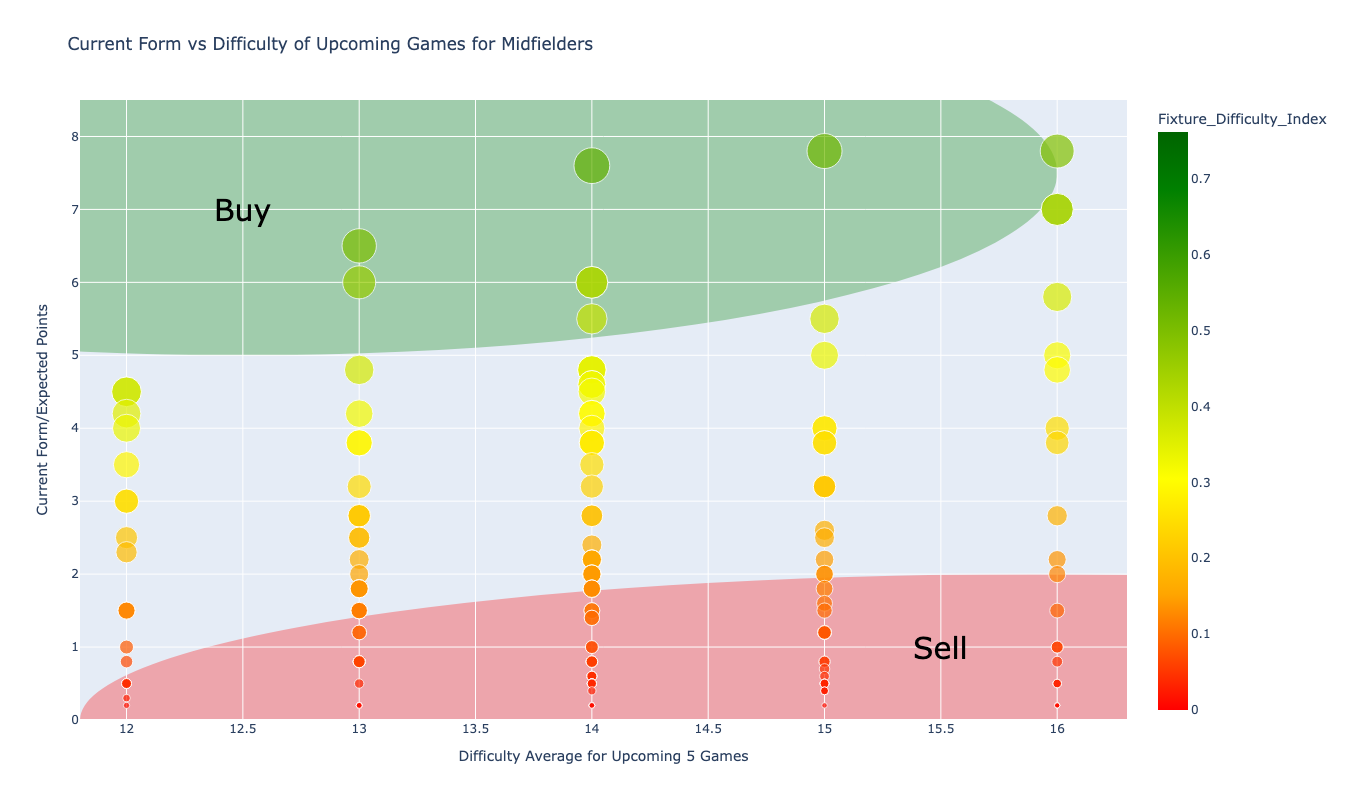

In [7]:

# Rename 'FD_index' to 'Fixture_Difficulty_Index'. Did this here to keep main df cleaner
sorted_midfielders_df.rename(columns={'FD_index': 'Fixture_Difficulty_Index'}, inplace=True)

# Wanted interactive scatter plot with hover information so that I could see the player, team, price and FD index without it being on the axis
fig = px.scatter(sorted_midfielders_df, x='Difficulty_score', y='form_player', color='Fixture_Difficulty_Index', #used to visualise quickly which is best pick
                 size='Fixture_Difficulty_Index',  
                 labels={'form_player': 'Current Form/Expected Points', 'Difficulty_score': 'Difficulty Average for Upcoming 5 Games'},
                 hover_data=['full_name', 'Fixture_Difficulty_Index', 'name', 'now_cost'], title='Current Form vs Difficulty of Upcoming Games for Midfielders',
                 size_max=30,  
                 color_continuous_scale=[
                    (0.0, 'red'),
                    (0.2, 'orange'),
                    (0.4, 'yellow'),
                    (0.9, 'green'),
                    (1.0, 'darkgreen') # so I tried to get this to fade from green -buy, to red -sell, and everything else yellow and orange, sorta worked
                 ]
                )

""" Add circles and text for the suggested buy and sell regions. Couldnt find a better way to do this without installing a lot of things Im not
familar with and didn't have time to learn. Brute force did the trick though
"""
fig.update_layout(
    shapes=[
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=9,
            y0=10,
            x1=16,
            y1=5,
            fillcolor='green',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        ),
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=11.8,
            y0=2,
            x1=20,
            y1=-2,
            fillcolor='red',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        )
    ],
    annotations=[
        dict(
            text='Buy', #thought it was clear, but Esky did say to make things clearer, than not :D
            x=12.5,  
            y=7,   
            showarrow=False,
            font=dict(color='black', size=30),
        ),
        dict(
            text='Sell',
            x=15.5,  
            y=1,   
            showarrow=False,
            font=dict(color='black', size=30),
        )
    ]
)


fig.update_layout(showlegend=False, height=800)  

# Circles were going too far out, so had to zoom in 
fig.update_xaxes(range=[11.8, 16.3])
fig.update_yaxes(range=[0, 8.5])

fig.show()


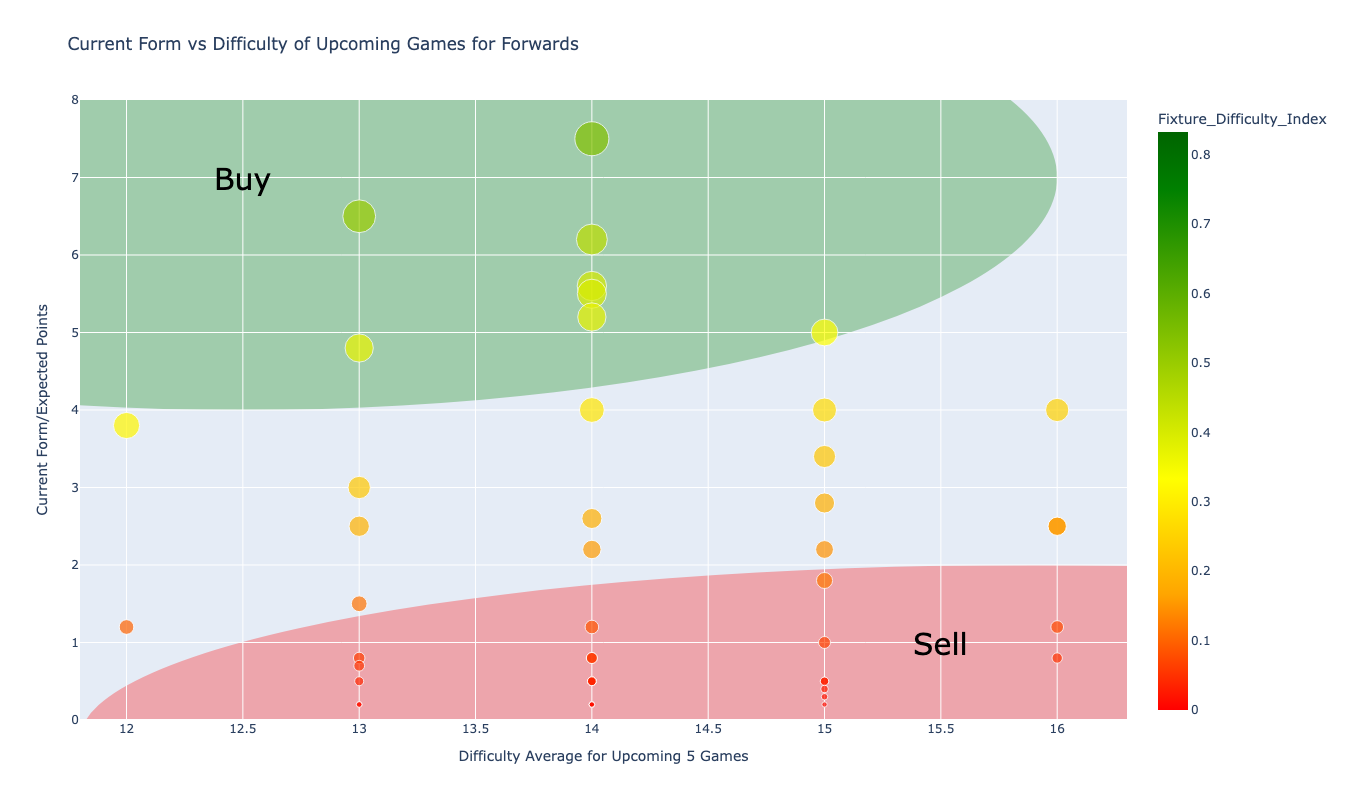

In [8]:
# Now the same for Forwards
sorted_forwards_df.rename(columns={'FD_index': 'Fixture_Difficulty_Index'}, inplace=True)


fig = px.scatter(sorted_forwards_df, x='Difficulty_score', y='form_player', color='Fixture_Difficulty_Index', 
                 size='Fixture_Difficulty_Index',  
                 labels={'form_player': 'Current Form/Expected Points', 'Difficulty_score': 'Difficulty Average for Upcoming 5 Games'},
                 hover_data=['full_name', 'Fixture_Difficulty_Index', 'name', 'now_cost'], title='Current Form vs Difficulty of Upcoming Games for Forwards',
                 size_max=30,  
                 color_continuous_scale=[
                    (0.0, 'red'),
                    (0.2, 'orange'),
                    (0.4, 'yellow'),
                    (0.9, 'green'),
                    (1.0, 'darkgreen') 
                 ]
                )


fig.update_layout(
    shapes=[
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=9,
            y0=10,
            x1=16,
            y1=4,
            fillcolor='green',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        ),
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=11.8,
            y0=2,
            x1=20,
            y1=-2.5,
            fillcolor='red',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        )
    ],
    annotations=[
        dict(
            text='Buy', 
            x=12.5,  
            y=7,   
            showarrow=False,
            font=dict(color='black', size=30),
        ),
        dict(
            text='Sell',
            x=15.5,  
            y=1,   
            showarrow=False,
            font=dict(color='black', size=30),
        )
    ]
)


fig.update_layout(showlegend=False, height=800)  


fig.update_xaxes(range=[11.8, 16.3])
fig.update_yaxes(range=[0, 8])

fig.show()


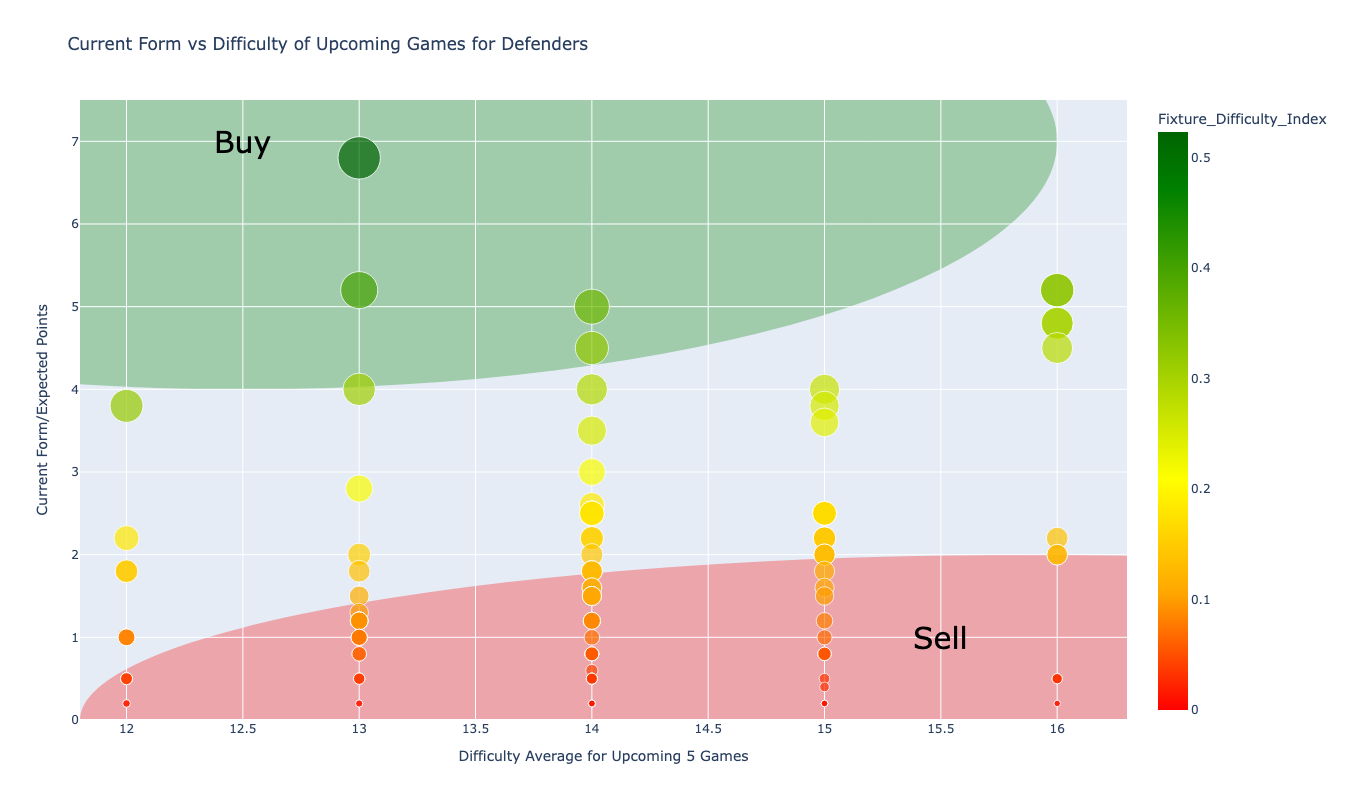

In [9]:
# Now the same for defenders
sorted_defenders_df.rename(columns={'FD_index': 'Fixture_Difficulty_Index'}, inplace=True)

fig_defenders = px.scatter(sorted_defenders_df, x='Difficulty_score', y='form_player', color='Fixture_Difficulty_Index', 
                           size='Fixture_Difficulty_Index',  
                           labels={'form_player': 'Current Form/Expected Points', 'Difficulty_score': 'Difficulty Average for Upcoming 5 Games'},
                           hover_data=['full_name', 'Fixture_Difficulty_Index', 'name', 'now_cost'], title='Current Form vs Difficulty of Upcoming Games for Defenders',
                           size_max=30,  
                           color_continuous_scale=[
                               (0.0, 'red'),
                               (0.2, 'orange'),
                               (0.4, 'yellow'),
                               (0.9, 'green'),
                               (1.0, 'darkgreen') 
                           ]
                          )


fig_defenders.update_layout(
    shapes=[
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=9,
            y0=10,
            x1=16,
            y1=4,
            fillcolor='green',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        ),
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=11.8,
            y0=2,
            x1=20,
            y1=-2,
            fillcolor='red',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        )
    ],
    annotations=[
        dict(
            text='Buy',
            x=12.5,  
            y=7,   
            showarrow=False,
            font=dict(color='black', size=30),
        ),
        dict(
            text='Sell',
            x=15.5,  
            y=1,   
            showarrow=False,
            font=dict(color='black', size=30),
        )
    ]
)

fig_defenders.update_layout(showlegend=False, height=800)  

fig_defenders.update_xaxes(range=[11.8, 16.3])
fig_defenders.update_yaxes(range=[0, 7.5])

fig_defenders.show()


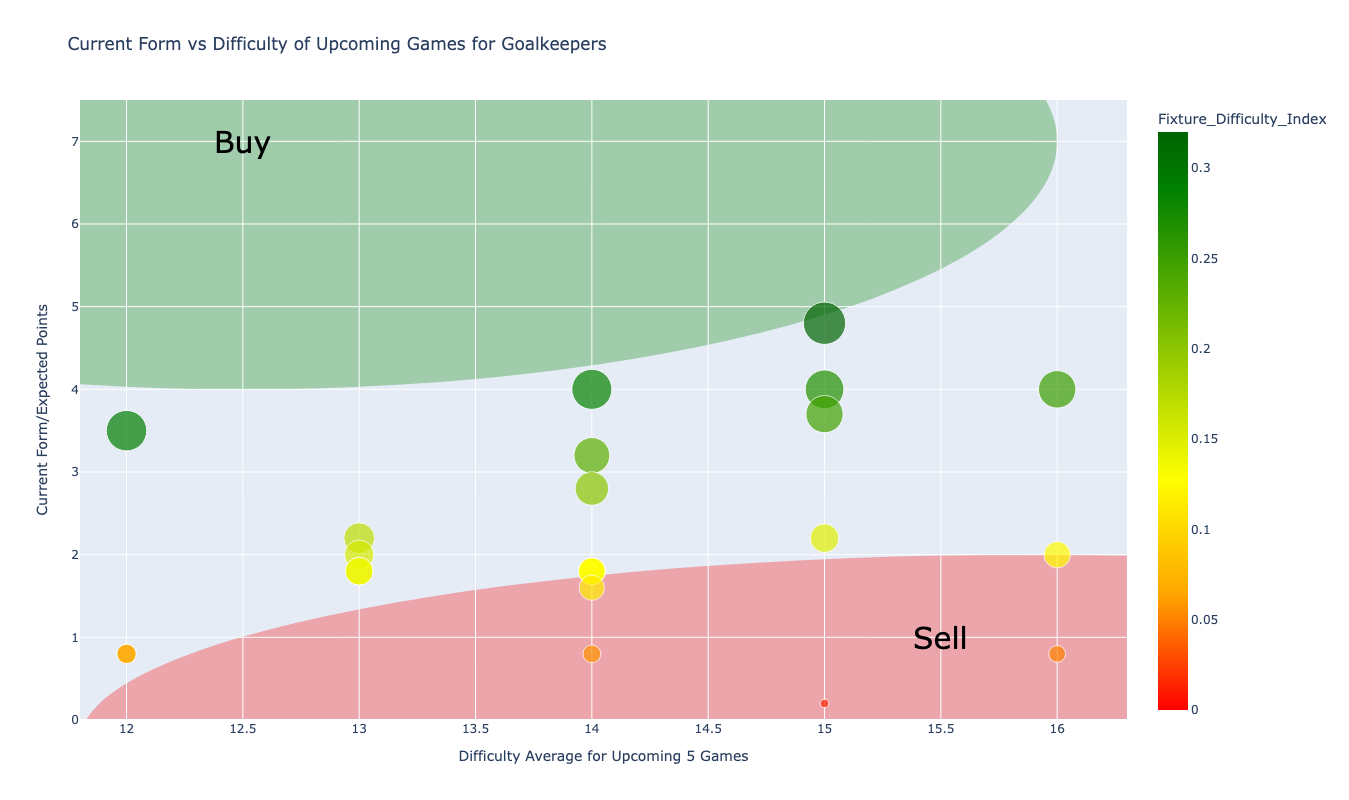

In [10]:
# Now the same for Goalkeepers
sorted_goalkeepers_df.rename(columns={'FD_index': 'Fixture_Difficulty_Index'}, inplace=True)

fig_goalkeepers = px.scatter(sorted_goalkeepers_df, x='Difficulty_score', y='form_player', color='Fixture_Difficulty_Index', 
                 size='Fixture_Difficulty_Index',  
                 labels={'form_player': 'Current Form/Expected Points', 'Difficulty_score': 'Difficulty Average for Upcoming 5 Games'},
                 hover_data=['full_name', 'Fixture_Difficulty_Index', 'name', 'now_cost'], title='Current Form vs Difficulty of Upcoming Games for Goalkeepers',
                 size_max=30,  
                 color_continuous_scale=[
                    (0.0, 'red'),
                    (0.2, 'orange'),
                    (0.4, 'yellow'),
                    (0.9, 'green'),
                    (1.0, 'darkgreen') 
                 ]
                )


fig_goalkeepers.update_layout(
    shapes=[
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=9,
            y0=10,
            x1=16,
            y1=4,
            fillcolor='green',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        ),
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=11.8,
            y0=2,
            x1=20,
            y1=-2.5,
            fillcolor='red',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        )
    ],
    annotations=[
        dict(
            text='Buy', 
            x=12.5,  
            y=7,   
            showarrow=False,
            font=dict(color='black', size=30),
        ),
        dict(
            text='Sell',
            x=15.5,  
            y=1,   
            showarrow=False,
            font=dict(color='black', size=30),
        )
    ]
)

fig_goalkeepers.update_layout(showlegend=False, height=800)  

 
fig_goalkeepers.update_xaxes(range=[11.8, 16.3])
fig_goalkeepers.update_yaxes(range=[0, 7.5])

fig_goalkeepers.show()
